In [137]:
%autosave 60
%pylab inline

import os
import re
import sys
import time
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
from tqdm import tqdm
from matplotlib.font_manager import FontProperties
from dateutil.relativedelta import relativedelta

current_directory = os.path.dirname(os.getcwd()) 
data_folder = os.path.normpath(os.path.join(current_directory + "/data"))

Autosaving every 60 seconds
Populating the interactive namespace from numpy and matplotlib


D:\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['legend']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


# Descriptive stats

In [2]:
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize

In [4]:
df = pd.read_csv(os.path.join(data_folder + "/main_upd4.csv"), encoding="utf-8", sep=";")
df.date = pd.to_datetime(df.date).dt.date
df = df[df.date < datetime.date(2022, 1, 1)]
df.type = df.type.str.replace("Пресс-релиз", "0").str.replace("Выступление", "1").astype(int)
df.tail()

,date,type,header,text,url,rate_flag,splittext
12639,2021-12-30,0,Прекращена деятельность временной администраци...,Временная администрация Общества с ограниченно...,https://www.cbr.ru/press/pr/?file=30122021_155...,0,NaN
12640,2021-12-30,0,Прекращена деятельность временной администраци...,Банк России 30.12.2021 прекратил деятельность ...,https://www.cbr.ru/press/pr/?file=30122021_170...,0,NaN
12641,2021-12-30,0,Опубликована Программа обследований Банка Росс...,На официальном сайте Банка России размещена Пр...,https://www.cbr.ru/press/pr/?file=30122021_150...,0,NaN
12642,2021-12-30,0,"Вышел очередной номер ""Вестника Банка России""","Вышел ""Вестник Банка России"" № 92 (2332) от 30...",https://www.cbr.ru/press/pr/?file=30122021_140...,0,NaN
12643,2021-12-30,0,Информация о сопоставлении рейтинговых шкал ро...,Банк России публикует таблицу сопоставления ре...,https://www.cbr.ru/press/pr/?file=30122021_101...,0,NaN


In [58]:
# pd.set_option('display.precision', 1)
df['text_len'] = df.text.str.len()
df_stats = df.groupby(["type", "rate_flag"])['text_len'].agg(["count","mean",'min', 'max']).reset_index()
df_stats.type = df_stats.type.astype(str).str.replace("0","Press-release").str.replace("1","Statement")
df_stats.rate_flag = df_stats.rate_flag.astype(str).str.replace("0","Other").str.replace("1","On rate")
df_stats2 = df.groupby(["type"])['text_len'].agg(["count","mean",'min', 'max']).reset_index()
df_stats2.type = df_stats2.type.astype(str).str.replace("0","Press-release").str.replace("1","Statement")
df_stats2['rate_flag'] =""
df_stats2 = df_stats2[df_stats.columns]
df_stats.columns = ['type', 'rate_flag', 'Num of obs.', 'Average num of symbols', 
                    'Minimum num of symbols', 'Maximum num of symbols']
df_stats2.columns = df_stats.columns

In [8]:
stats = []
for i, text in zip(df.index, df.text):
    stats.append([len(sent_tokenize(text)), len(word_tokenize(text))])
df["numsent"] = np.array(stats).T[0]
df["numwords"] = np.array(stats).T[1]

In [65]:
df_stats['Average num of sententences'] = df.groupby(["type", "rate_flag"])['numsent'].agg(["mean"]).reset_index()['mean']
df_stats['Average num of words'] = df.groupby(["type", "rate_flag"])['numwords'].agg(["mean"]).reset_index()['mean']
df_stats2['Average num of sententences'] = df.groupby(["type"])['numsent'].agg(["mean"]).reset_index()['mean']
df_stats2['Average num of words'] = df.groupby(["type"])['numwords'].agg(["mean"]).reset_index()['mean']
df_stats_fin = pd.concat([df_stats2, df_stats]).sort_values(by=['type'])
print(df_stats_fin.to_latex(index=False).replace("\t", " "))

\begin{tabular}{llrrrrrr}
\toprule
          type & rate\_flag &  Num of obs. &  Average num of symbols &  Minimum num of symbols &  Maximum num of symbols &  Average num of sententences &  Average num of words \\
\midrule
 Press-release &           &        12521 &                  1444.9 &                     131 &                   31075 &                          5.3 &                 216.8 \\
 Press-release &     Other &        12410 &                  1414.8 &                     131 &                   31075 &                          5.0 &                 212.6 \\
 Press-release &   On rate &          111 &                  4805.3 &                     496 &                   10143 &                         35.0 &                 683.6 \\
     Statement &           &          123 &                 22649.0 &                     192 &                   43320 &                        192.5 &                3690.4 \\
     Statement &     Other &           82 &                 18790

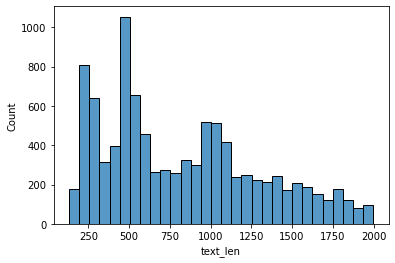

In [98]:
df_temp = df[(df.type == 0) & (df.rate_flag == 0) & (df.text_len < 2000)]
sns.histplot(df_temp.text_len)

# Simple methods

## Dictionary-based (HOLD)

## Dostoevsky
https://pypi.org/project/dostoevsky/

In [328]:
# pip install dostoevsky

In [67]:
import dostoevsky
from dostoevsky.tokenization import RegexTokenizer
from dostoevsky.models import FastTextSocialNetworkModel

tokenizer = RegexTokenizer()
model = FastTextSocialNetworkModel(tokenizer=tokenizer)

def metrics_vec(results):
    metrics = [[i['negative'], i['positive'], i['neutral']] for i in results]
    metrics = np.array(metrics)
    metrics_sum = metrics.sum(axis=1)
    return (metrics / metrics_sum[:, np.newaxis]).T

In [68]:
%%time
messages = df.text.tolist()

allresults = model.predict(messages, k=5)

Wall time: 42.1 s


In [107]:
metrics = metrics_vec(allresults)
df['negative'] = metrics[0]
df['positive'] = metrics[1]
df['tone'] = (df['positive'] - df['negative'])

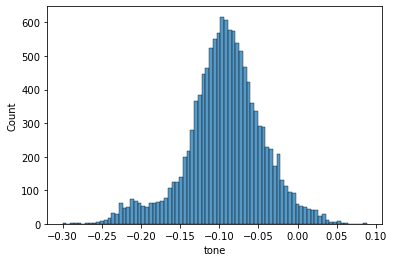

In [108]:
sns.histplot(df.tone)
plt.show()

In [123]:
df['tone'] = (df['positive'] - df['negative'])

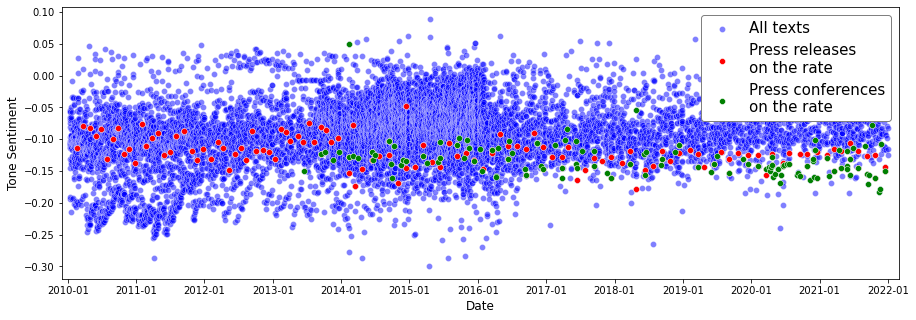

In [157]:
# overall

fig, ax = plt.subplots(1, 1, figsize=(15, 5))

sns.scatterplot(x = df.date, y = df.tone, alpha=0.5, color='b', label='All texts')
sns.scatterplot(x = df[df.rate_flag == 1].date, y = df[df.rate_flag == 1].tone, alpha=1, color='r', 
                label='Press releases\non the rate')
sns.scatterplot(x = df[df.type == 1].date, y = df[df.type == 1].tone, alpha=1, color='g', 
                label='Press conferences\non the rate')

    
# sns.lineplot(x = df_rates.date, y = df_rates.rate_real, color = 'black',label="Current rate", alpha=0.8, linewidth=2)
plt.xlim((datetime.date(2009, 12, 1), datetime.date(2022, 3, 1)))


ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Tone Sentiment', fontsize=12)

legend = plt.legend(loc="upper right", edgecolor="grey", fontsize=15)
legend.get_frame().set_alpha(None)

fig.patch.set_facecolor('white')
ax.set_xticks([datetime.date(2010, 1, 1) + relativedelta(years=i) for i in range(0, 13)])
ax.set_xticklabels([(datetime.date(2010, 1, 1) + relativedelta(years=i)).strftime("%Y-%m") for i in range(0, 14)])

# locs, labels = xticks()  # Get the current locations and labels.
# xticks(np.arange(73042, 738157, 730/2))  # Set text labels.
plt.show()

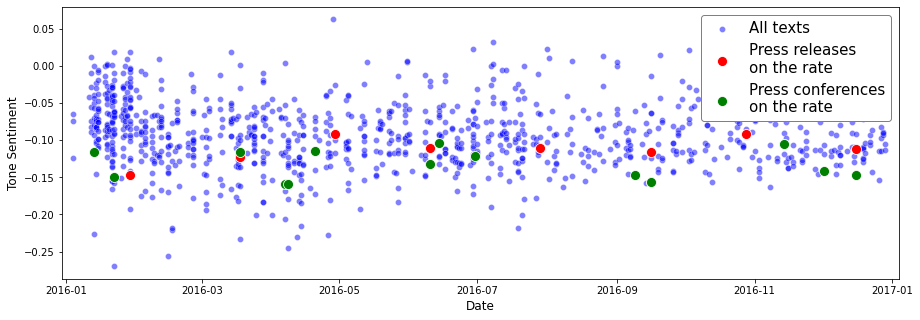

In [158]:
# overall

fig, ax = plt.subplots(1, 1, figsize=(15, 5))

df_temp = df[(df.date > datetime.date(2015, 12, 31)) & (df.date < datetime.date(2016, 12, 31))]

sns.scatterplot(x = df_temp.date, y = df_temp.tone, alpha=0.5, color='b', label='All texts')
sns.scatterplot(x = df_temp[df_temp.rate_flag == 1].date, y = df_temp[df_temp.rate_flag == 1].tone, s=100, alpha=1, color='r', 
                label='Press releases\non the rate')
sns.scatterplot(x = df_temp[df_temp.type == 1].date, y = df_temp[df_temp.type == 1].tone, alpha=1, s=100, color='g', 
                label='Press conferences\non the rate')

    
plt.xlim(df_temp.date.min() - relativedelta(days=5), df_temp.date.max() + relativedelta(days=5))


ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Tone Sentiment', fontsize=12)

legend = plt.legend(loc="upper right", edgecolor="grey", fontsize=15)
legend.get_frame().set_alpha(None)

fig.patch.set_facecolor('white')

plt.show()

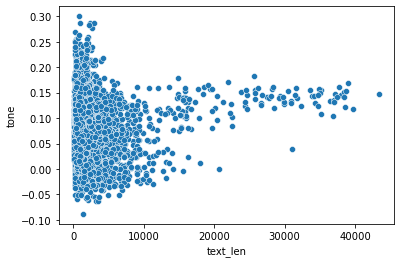

In [73]:
sns.scatterplot(x = df.text_len, y = df.tone)
plt.show()

In [135]:
df.to_csv("main_upd5.csv", encoding="utf-8", sep=";", index=False)

In [6]:
df[df.rate_flag ==1].groupby("type")['date'].count()

type
0    111
1     41
Name: date, dtype: int64

# Продвинутые метрики (HOLD)

# Добавляем рыночные метрики

In [138]:
df = pd.read_csv(os.path.join(data_folder + "/main_upd5.csv"), encoding="utf-8", sep=";")
df.date = pd.to_datetime(df.date).dt.date
df.head()

,date,type,header,text,url,rate_flag,splittext,text_len,numsent,numwords,negative,positive,tone
0,2010-01-11,0,О результатах мониторинга максимальных процент...,Департамент внешних и общественных связей Банк...,http://www.cbr.ru/press/PR/?file=100111_133902...,0,NaN,801,3,137,0.094714,0.013910,-0.080804
1,2010-01-11,0,Об условиях проведения Банком России 11.01.201...,Департамент внешних и общественных связей Банк...,http://www.cbr.ru/press/PR/?file=100111_104827...,0,NaN,553,2,77,0.181789,0.076406,-0.105383
2,2010-01-11,0,О проведении ломбардных кредитных аукционов,Департамент внешних и общественных связей Банк...,http://www.cbr.ru/press/PR/?file=100111_161453...,0,NaN,322,1,48,0.149605,0.085060,-0.064544
3,2010-01-12,0,Об условиях проведения Банком России 12.01.201...,Департамент внешних и общественных связей Банк...,http://www.cbr.ru/press/PR/?file=100112_112503...,0,NaN,553,2,77,0.183338,0.077057,-0.106281
4,2010-01-12,0,Об итогах проведения ломбардных кредитных аукц...,Департамент внешних и общественных связей Банк...,http://www.cbr.ru/press/PR/?file=100112_181233...,0,NaN,1726,6,281,0.250569,0.055870,-0.194700


In [133]:
# df_temp = df[df.rate_flag == 1]
# plt.scatter(df_temp.date, df_temp['positive'] / (df_temp['positive'] + df_temp['negative']) )
# df_temp = df[(df.rate_flag == 1) & (df.type == 1)]
# plt.scatter(df_temp.date, df_temp['positive'] / (df_temp['positive'] + df_temp['negative']) )

### Ключевая ставка

In [206]:
months = {"января": "01",
"февраля": "02",
"марта": "03",
"апреля": "04",
"мая": "05",
"июня": "06",
"июля": "07",
"августа": "08",
"сентября": "09",
"октября": "10",
"ноября": "11",
"декабря": "12"}

In [207]:
df_rate = pd.read_csv(os.path.join(data_folder + "/key_rate.csv"))
df_rate['announced_date'] = pd.to_datetime(df_rate['announced_date'], format="%d.%m.%Y").dt.date
dates = []
for i in df_rate.actual_date:
    l = i.split()
    dates.append(l[0]+"."+months[l[1]]+"."+l[2])
df_rate['actual_date'] = dates
df_rate['actual_date'] = pd.to_datetime(df_rate['actual_date'], format="%d.%m.%Y").dt.date
df_rate['rate'] = df_rate['rate'].str.replace(",",".").astype(float)

In [208]:
df_short = df[(df.date >= datetime.date(2013, 9, 13)) & (df.rate_flag == 1)].reset_index(drop=True)

announced_rates = dict(df_rate[['announced_date','rate']].to_numpy())
# df_short.date.apply(lambda x: announced_rates[x])
all_dates = pd.DataFrame(np.arange(df_short.date.min(), df_short.date.max()+datetime.timedelta(1)), columns = ['date'])
df_announced_rates = all_dates.copy()

curmin = min(list(announced_rates.keys()))
r = [announced_rates.pop(curmin)]
for d in all_dates.date[1:]:
    curmin2 = min(list(announced_rates.keys()))
    if d >= curmin2:
        curmin = curmin2
        r.append(announced_rates.pop(curmin))
    else:
        r.append(r[-1])
df_announced_rates['rate'] = r

actual_rates = dict(df_rate[['actual_date','rate']].to_numpy())
df_real_rates = all_dates.copy()
curmin = min(list(actual_rates.keys()))
r = [actual_rates.pop(curmin)]
for d in all_dates.date[1:]:
    curmin2 = min(list(actual_rates.keys()))
    if d >= curmin2:
        curmin = curmin2
        r.append(actual_rates.pop(curmin))
    else:
        r.append(r[-1])
df_real_rates['rate'] = r

df_rates = pd.merge(df_announced_rates, df_real_rates, left_on="date", right_on='date', suffixes=("_announced", "_real"))
df_rates['date'] = df_rates['date'].dt.date
df_rates.tail()

df_short = pd.merge(df_short, df_rates, how="left", left_on="date", right_on='date')
df_short['rate_shock_abs'] = df_short.rate_announced - df_short.rate_real
df_short['rate_shock_rel'] = df_short.rate_shock_abs / df_short.rate_real
# df_short = df_short[(df_short.date > datetime.date(2013, 9, 13))].reset_index(drop=True)
df_short.tail(3)

,date,type,header,text,url,rate_flag,splittext,text_len,numsent,numwords,negative,positive,tone,rate_announced,rate_real,rate_shock_abs,rate_shock_rel
108,2021-10-22,0,Банк России принял решение повысить ключевую с...,Совет директоров Банка России 22 октября 2021 ...,https://www.cbr.ru/press/pr/?file=22102021_133...,1,NaN,9046,71,1276,0.187382,0.061726,-0.125656,7.5,6.75,0.75,0.111111
109,2021-12-17,1,Заявление Председателя Банка России Эльвиры На...,Добрый день! Мы приняли решение повысить ключе...,https://www.cbr.ru/press/event/?id=12542,1,Добрый день! Мы приняли решение повысить ключе...,25807,228,4279,0.243268,0.092965,-0.150303,8.5,7.50,1.00,0.133333
110,2021-12-17,0,Банк России принял решение повысить ключевую с...,Совет директоров Банка России 17 декабря 2021 ...,https://www.cbr.ru/press/pr/?file=17122021_133...,1,NaN,8486,65,1188,0.202485,0.058289,-0.144196,8.5,7.50,1.00,0.133333


In [209]:
df_short[df_short.rate_flag ==1].groupby("type")['date'].count()

type
0    70
1    41
Name: date, dtype: int64

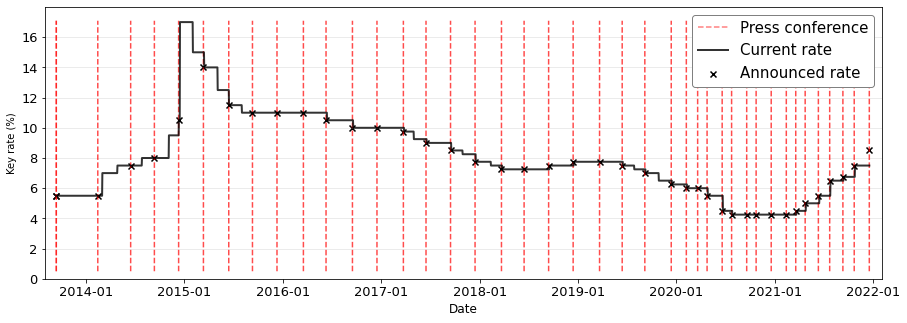

In [210]:
# font = FontProperties()
# font.set_family('serif')
# font.set_name('Calibri')
# font.set_style('italic')

fig, ax = plt.subplots(1, 1, figsize=(15, 5))


# y_ver = np.arange(2, 16)
y_ver = np.arange(0.5, 17.1, 0.01)
ax.scatter([datetime.date(2013, 9, 13)],[5.5], color='black', label='Announced rate', marker="x")
ax.plot([datetime.date(2013, 9, 13)] * y_ver.shape[0], y_ver, color = 'r', alpha=0.5, linestyle="--", 
        label='Press conference')
for i, j in  df_short[df_short.type == 1][["date", "rate_announced"]].to_numpy():
    ax.plot([i] * y_ver.shape[0], y_ver, color = 'r', alpha=0.7, linestyle="--")
    ax.scatter([i],[j], color='black', marker="x")
    
sns.lineplot(x = df_rates.date, y = df_rates.rate_real, color = 'black',label="Current rate", alpha=0.8, linewidth=2)

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Key rate (%)')
plt.xlim((datetime.date(2013, 8, 1), datetime.date(2022, 2, 1)))
plt.ylim(0, 18)
ax.yaxis.set_ticks(np.arange(0, 17, 2))
ax.set_xticks([datetime.date(2014, 1, 1) + relativedelta(years=i) for i in range(0, 9)])
ax.set_xticklabels([(datetime.date(2014, 1, 1) + relativedelta(years=i)).strftime("%Y-%m") for i in range(0, 9)])

legend = plt.legend(loc="upper right", edgecolor="grey", fontsize=15)
legend.get_frame().set_alpha(None)
# legend.get_frame().set_facecolor((0, 0, 1, 0.1))
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

ax.grid(axis='y', alpha=0.3)
fig.patch.set_facecolor('white')
plt.show()

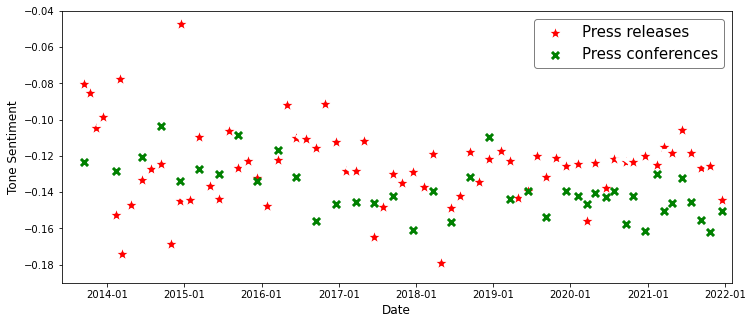

In [211]:
# выступления

fig, ax = plt.subplots(1, 1, figsize=(12, 5))

df_temp = df_short[df_short.type==0]
sns.scatterplot(x = df_temp.date, y = df_temp.tone, alpha=1, s=400, color='r', linewidth=3, marker="*", 
                label='Press releases')
df_temp = df_short[df_short.type==1]
sns.scatterplot(x = df_temp.date, y = df_temp.tone, alpha=1, s=50, color='g', linewidth=3, marker="x",
                label='Press conferences')

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Tone Sentiment', fontsize=12)

legend = plt.legend(loc="upper right", edgecolor="grey", fontsize=15)
legend.get_frame().set_alpha(None)

fig.patch.set_facecolor('white')

plt.xlim((datetime.date(2013, 6, 1), datetime.date(2022, 2, 1)))
plt.ylim((-0.19, -0.04))

ax.set_xticks([datetime.date(2014, 1, 1) + relativedelta(years=i) for i in range(0, 9)])
ax.set_xticklabels([(datetime.date(2014, 1, 1) + relativedelta(years=i)).strftime("%Y-%m") for i in range(0, 9)])
# ax.grid(axis='y', alpha=0.3)
plt.show()

### Добавляем контроль на доверие (клеим к конкретному датасету/ спецификации)

In [219]:
dft = pd.read_csv(os.path.join(data_folder + "/trust.csv"))
dft.columns = ['year', 'skip', 'idk', 'not', 'do']

#### MOEX

In [187]:
dfm = pd.read_csv(os.path.join(data_folder + "/imoex.csv"))
dfm['TRADEDATE'] = pd.to_datetime(dfm['TRADEDATE'], format="%d.%m.%Y").dt.date
dfm = dfm.sort_values(by='TRADEDATE')

for col in dfm.columns[-5:]:
    dfm[col] = dfm[col].str.replace(",", ".").astype(float)

dfm.CLOSE = dfm.CLOSE / dfm.OPEN[0]    
dfm.OPEN = dfm.OPEN / dfm.OPEN[0]
dfm.head()

,BOARDID,SECID,TRADEDATE,SHORTNAME,NAME,CLOSE,OPEN,HIGH,LOW,VALUE
0,SNDX,IMOEX,2010-01-11,Индекс МосБиржи,Индекс МосБиржи,1.054353,1.000000,1456.78,1370.30,5.205232e+10
1,SNDX,IMOEX,2010-01-12,Индекс МосБиржи,Индекс МосБиржи,1.041867,1.054353,1445.70,1424.73,3.882154e+10
2,SNDX,IMOEX,2010-01-13,Индекс МосБиржи,Индекс МосБиржи,1.047223,1.041830,1444.86,1412.87,4.222875e+10
3,SNDX,IMOEX,2010-01-14,Индекс МосБиржи,Индекс МосБиржи,1.062286,1.047223,1456.34,1435.01,4.451159e+10
4,SNDX,IMOEX,2010-01-15,Индекс МосБиржи,Индекс МосБиржи,1.060111,1.062154,1469.55,1448.68,4.267554e+10


In [188]:
dfm.isna().any()

BOARDID      False
SECID        False
TRADEDATE    False
SHORTNAME    False
NAME         False
CLOSE        False
OPEN         False
HIGH         False
LOW          False
VALUE        False
dtype: bool

In [189]:
(dfm.iloc[:, -5:] == 0).any()

CLOSE    False
OPEN     False
HIGH     False
LOW      False
VALUE     True
dtype: bool

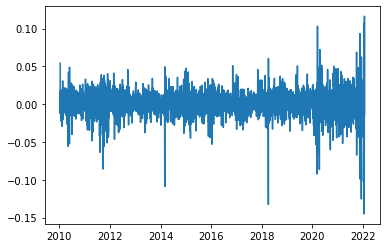

In [190]:
# SPREAD СЛАБО ПОДХОДИТ!
dfm['SPREAD'] = dfm['CLOSE'] - dfm['OPEN']
plt.plot(dfm.TRADEDATE, dfm.SPREAD)
plt.show()

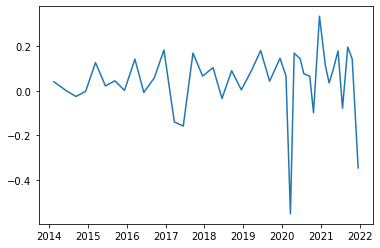

In [191]:
df_temp = df[(df.rate_flag == 1) & (df.type == 1)]
df_temp = pd.merge(df_temp, dfm[["TRADEDATE", "OPEN", "CLOSE", "SPREAD"]], 
                   how='left', left_on='date', right_on='TRADEDATE')
# df_temp.groupby("date")['url'].count().sort_values()
df_temp.head(3)
a = df_temp.CLOSE.tolist()[:-1]
df_temp = df_temp.iloc[1:]
df_temp['CLOSE_1'] = a
df_temp['CLOSE_SPREAD'] = df_temp['CLOSE'] - df_temp['CLOSE_1']
plt.plot(df_temp.TRADEDATE, df_temp.CLOSE_SPREAD)
plt.show()

In [195]:
model = smf.ols('CLOSE ~ tone', data=df_temp).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  CLOSE   R-squared:                       0.266
Model:                            OLS   Adj. R-squared:                  0.247
Method:                 Least Squares   F-statistic:                     13.77
Date:                Thu, 03 Mar 2022   Prob (F-statistic):           0.000658
Time:                        19:48:08   Log-Likelihood:                -27.630
No. Observations:                  40   AIC:                             59.26
Df Residuals:                      38   BIC:                             62.64
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.0123      0.776     -1.304      0.2

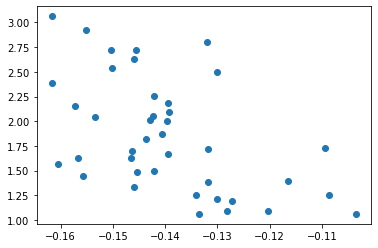

In [196]:
# важн
Y = df_temp['CLOSE']
X = df_temp.tone
plt.scatter(X, Y)
plt.show()

In [197]:
df_short = pd.merge(df_short, dfm[["TRADEDATE", "OPEN", "CLOSE", "SPREAD"]], 
         how='left', left_on='date', right_on='TRADEDATE').drop(columns=['TRADEDATE'])
df_short.head()

,date,type,header,text,url,rate_flag,splittext,text_len,numsent,numwords,negative,positive,tone,rate_announced,rate_real,rate_shock_abs,rate_shock_rel,OPEN,CLOSE,SPREAD
0,2013-09-13,1,Информация по итогам брифинга Председателя Бан...,"Добрый день, уважаемые коллеги. Я хочу рассказ...",https://www.cbr.ru/press/event/?id=5196,1,"Добрый день, уважаемые коллеги. Я хочу рассказ...",32388,285,5406,0.208317,0.084750,-0.123568,5.5,5.5,0.0,0.0,1.058644,1.051405,-0.007239
1,2013-09-13,0,О системе процентных инструментов денежно-кред...,О системе процентных инструментов денежно-кред...,http://www.cbr.ru/press/PR/?file=130913_135042...,1,NaN,6450,26,888,0.146969,0.066575,-0.080394,5.5,5.5,0.0,0.0,1.058644,1.051405,-0.007239
2,2013-10-14,0,О ключевой ставке Банка России,"Пресс-служба Банка России сообщает, что Совет ...",http://www.cbr.ru/press/PR/?file=131014_133001...,1,NaN,2986,19,403,0.148732,0.063687,-0.085044,5.5,5.5,0.0,0.0,1.103269,1.102094,-0.001175
3,2013-11-08,0,О ключевой ставке Банка России,Совет директоров Банка России 8 ноября 2013 го...,http://www.cbr.ru/press/PR/?file=131108_133008...,1,NaN,3059,20,423,0.189543,0.084913,-0.104629,5.5,5.5,0.0,0.0,1.100934,1.087025,-0.013909
4,2013-12-13,0,О ключевой ставке Банка России,Совет директоров Банка России 13 декабря 2013 ...,http://www.cbr.ru/press/PR/?file=131213_133004...,1,NaN,2778,19,379,0.187505,0.089238,-0.098267,5.5,5.5,0.0,0.0,1.057973,1.060177,0.002204


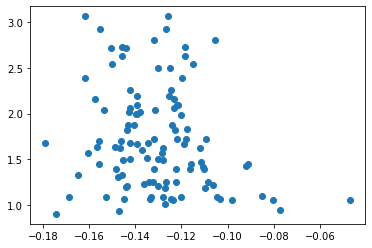

In [198]:
# важн
Y = df_short['CLOSE']
X = df_short.tone
plt.scatter(X, Y)
plt.show()

In [201]:
df_short = df_short.rename(columns={"OPEN":"moex_open","CLOSE":"moex_closed","SPREAD":"moex_spread"})

In [207]:
# # тональность не зависит от шока!
# # но немного зависит от анонсированной ставки...
# sns.scatterplot(x=df_short.tone, y=df_short.rate_shock_abs)
# model = smf.ols('tone ~ rate_announced', data=df_short).fit()
# print(model.summary())
# plt.show()

#### RTS

In [202]:
dfr = pd.read_csv(os.path.join(data_folder + "/rtsi.csv"))
dfr['TRADEDATE'] = pd.to_datetime(dfr['TRADEDATE'], format="%d.%m.%Y").dt.date
dfr = dfr.sort_values(by='TRADEDATE')

for col in dfr.columns[-5:]:
    dfr[col] = dfr[col].str.replace(",", ".").astype(float)

dfr.CLOSE = dfr.CLOSE / dfr.OPEN[0]    
dfr.OPEN = dfr.OPEN / dfr.OPEN[0]
dfr.head()

,BOARDID,SECID,TRADEDATE,SHORTNAME,NAME,CLOSE,OPEN,HIGH,LOW,VALUE
0,RTSI,RTSI,2010-01-11,Индекс РТС,Индекс РТС,1.075005,1.000000,1561.80,1444.70,3.201883e+08
1,RTSI,RTSI,2010-01-12,Индекс РТС,Индекс РТС,1.063044,1.073026,1559.75,1528.09,3.482365e+08
2,RTSI,RTSI,2010-01-13,Индекс РТС,Индекс РТС,1.064879,1.063044,1548.46,1512.81,3.408507e+08
3,RTSI,RTSI,2010-01-14,Индекс РТС,Индекс РТС,1.081131,1.064837,1561.91,1538.22,2.945995e+08
4,RTSI,RTSI,2010-01-15,Индекс РТС,Индекс РТС,1.079290,1.081131,1573.90,1553.83,3.889666e+08


In [203]:
# # SPREAD СЛАБО ПОДХОДИТ!
# dfr['SPREAD'] = dfr['CLOSE'] - dfr['OPEN']
# plt.plot(dfr.TRADEDATE, dfr.SPREAD)
# plt.show()

dfr.isna().any(), (dfr.iloc[:, -5:] == 0).any()

(BOARDID      False
 SECID        False
 TRADEDATE    False
 SHORTNAME    False
 NAME         False
 CLOSE        False
 OPEN         False
 HIGH         False
 LOW          False
 VALUE        False
 dtype: bool,
 CLOSE    False
 OPEN     False
 HIGH     False
 LOW      False
 VALUE    False
 dtype: bool)

In [204]:
df_temp = df[(df.rate_flag == 1) & (df.type == 1)]
df_temp = pd.merge(df_temp, dfr[["TRADEDATE", "OPEN", "CLOSE", "SPREAD"]], how='left', left_on='date', right_on='TRADEDATE')
# df_temp.groupby("date")['url'].count().sort_values()
df_temp.head(3)

In [205]:
model = smf.ols('CLOSE ~ tone', data=df_temp).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  CLOSE   R-squared:                       0.266
Model:                            OLS   Adj. R-squared:                  0.247
Method:                 Least Squares   F-statistic:                     13.77
Date:                Thu, 03 Mar 2022   Prob (F-statistic):           0.000658
Time:                        19:51:40   Log-Likelihood:                -27.630
No. Observations:                  40   AIC:                             59.26
Df Residuals:                      38   BIC:                             62.64
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.0123      0.776     -1.304      0.2

In [ ]:
df_short.to_csv("final01.csv", encoding="utf-8", sep=";", index=False)
df_short.head()